This notebook implements the decision making algorithm presented in the paper [Near Optimal Bayesian Active Learning for Decision Making](http://www.ri.cmu.edu/pub_files/2014/4/javdani14hec_extended.pdf) by [Shervin Javdani](http://www.cs.cmu.edu/~sjavdani/) et al.

In [1]:
%matplotlib inline
from itertools import combinations_with_replacement, permutations, combinations
from matplotlib import pyplot as plt
import numpy as np
import random
import time

Problem Motivation
------------------

Imagine you are a robot that desprately needs to push a button.... 



Problem Introduction
-------

In the domain of active learning for decision making, our task is find the true hypothesis from a set of finite hypotheses $\mathcal{H}$. At our disposal is a set of finite, deterministic tests $\mathcal{T}$ that we can conduct. Each test results in a piece of evidence, allowing us to rule out hypotheses that are inconsistent with the evidence. The challenge is to create an algorithm that will find the true hypothesis while conducting as few tests as possible. 

A prototype for such an algorithm would be the following:

In [1]:
def find_true_hypothesis(hypotheses, tests):
  true_hypothesis = None
  while true_hypothesis == None:
    # Do some tests to figure out the true hypothesis.
    pass
  return true_hypohtesis

This function is provided the set of hypotheses $\mathcal{H}$ and the set of tests $\mathcal{T}$ and outputs the true hypothesis. We will take the Bayesian point of view and we will require a prior probability $P(h)$ for each hypothesis $h\in{}\mathcal{H}$.

To make things a little more general, rather than requiring our algorithm to return the one true hypothesis in $\mathcal{H}$ we will allow our algorithm to return a "decision region" that is guaranteed to contain the true hypothesis. Decision regions can be thought of as groups of hypotheses for which you will perform the same action regardless of which hypothesis in the region is the true hypothesis. 

Our prototype function would be updated to:

In [3]:
def determine_correct_decision(hypotheses, decision_regions, tests):
  correct_decision_region = None
  while correct_decision_region == None:
    # Do some tests to figure out which decision region contains the true hypothesis
    pass
  return correct_decision_region

This function is still given the set of all hypotheses $\mathcal{H}$ (with prior probabilities) and the set of tests $\mathcal{T}$. In addition, we provide the function with a set of available decision regions $\mathcal{R}$. We require that all hypotheses are contained in at least one decision region. The output of the function is now a decision region that is guaranteed to contain the true hypothesis.

Before implementing this function, we need to define the hypotheses, the decision regions and the tests. To keep things easy to visualize, we will define hypotheses as 2d points. One of these hypotheses will be the "true hypothesis." Decision regions will be circles, and a hypothesis will be a member of a decision region if it is contained within the decision region's circle. Tests will be conducted between two points. The point closer to the true hypothesis (euclidean distance) will be returned as the evidence. 

In [2]:
# GVH: Consider renaming to Value so that we aren't doing point.point in the code.
class Point():
  """
  The value of a hypothesis. 
  
  In this example, it will be a 2d point.
  """
  
  def __init__(self, name, point):
    """
    Args:
      name (str): A name for this point.
      point (numpy.ndarray): A 2d numpy array for this point. 
    """
    self.name = name
    self.point = point

  def __str__(self):
    return "%s (%s)" % (self.name, self.point,)

In [3]:
class Test():
  """
  A test decides the closer of two points to a specified point. 
  """
  
  def __init__(self, point1, point2):
    """
    Args:
      point1 (Point): The first of two points to compare.
      point2 (Point): The second of two points to compare.
    """
    self.point1 = point1
    self.point2 = point2
  
  def run(self, correct_point):
    """
    Test which point is closer to the `correct_point.`
    
    Args:
      correct_point (Point): The point to compute distances from.
    
    Returns:
      Point: Either `point1` or `point2`, which ever is closer to the `correct_point.`
    """
    
    dist1 = np.linalg.norm(self.point1.point - correct_point.point)
    dist2 = np.linalg.norm(self.point2.point - correct_point.point)
    
    if dist1 < dist2:
      return self.point1
    else:
      return self.point2
    
  def __str__(self):
    return "%s vs %s" % (self.point1, self.point2)

In [4]:
class Hypothesis():
  """
  A representation of a hypothesis. 
  """
  
  def __init__(self, point, prior, decision_regions):
    """
    Args:
      point (Point): The value for this hypothesis.
      prior (float): The prior probability for this hypothesis. Should be between [0,1].
      decision_regions (List[DecisionRegion]): a list of DecisionRegions that this 
        hypothesis belongs to.
    """
    
    self.point = point
    self.prior = prior
    self.decision_regions = decision_regions
    self.consistent = True
    
  def test(self, test):
    """
    Run the test under the assumption that this hypothesis is the correct hypothesis.
    
    Args:
      test (Test): The test to run.
    
    Returns:
      Point: The point closer to the value of this hypothesis. 
    """
    
    return test.run(self.point)
  
  
  def conditional_probability(self, evidence):
    """
    Compute the likelihood of this hypothesis given the evidence. In this case, the value
    will either be 1 or 0 depending on if our point passes all the tests.
    
    Args:
      evidence (List[(Test, Point)]): A list of test, outcome pairs.
    
    Returns:
      float: 1.0 or 0.0 depending on if this hypothesis is still consistent with the evidence.
    """
    p = 1.
    for test, outcome in evidence:
      if test.run(self.point) != outcome:
        p = 0.
    return p
  
  def render(self):
    """
    Render this hypothesis on the current figure.
    """
    x, y = self.point.point
    plt.plot(x, y, 'bo')
    plt.annotate(
      self.point.name, 
      xy = (x, y), xytext = (5, -20),
      textcoords = 'offset points', ha = 'right', va = 'bottom'
    )
    
  def __str__(self):
   return "%s" % (self.point,)

In [5]:
class DecisionRegion():
  """
  A circular region of the hypothesis space. 
  """
  def __init__(self, _id, center, radius, color):
    """
    Args:
      _id (int): An identifier for this decision region.
      center (numpy.ndarray): The center of the circle.
      radius (float): The radius of the circle.
      color: The color of the circle. This is passed to pyplot. 
    """
    
    self._id = _id
    self.hypotheses = set()
    self.center = center
    self.radius = radius
    self.color = color
    pass
  
  def generate_random_point(self):
    """
    Generate a random point within this decision region.
    
    Returns:
      numpy.ndarray: A 2d numpy array.
    """
    t = 2*np.pi*np.random.rand()
    u = np.random.rand()+np.random.rand()
    r = 2-u if u>1 else u
    p = self.center + np.array([r*np.cos(t), r*np.sin(t)]) * self.radius
    return p
    
  def contains_point(self, point):
    """
    Does this decision region contain this point? 
    
    Args:
      point (numpy.ndarray): A 2d numpy array. 
    
    Returns:
      bool: True or False depending on if the point is within the circle
        of this decision region.
    """
    return np.sum((point - self.center) ** 2) <= self.radius ** 2
  
  def contains_hypothesis(self, hypothesis):
    """
    Is the hypothesis within this decision region?
    
    Args:
      hypothesis (Hypothesis): The hypothesis to check.
    
    Returns:
      bool: True or False depending on if the hypothesis is in the decision region.
    """
    return np.sum((hypothesis.point.point - self.center) ** 2) <= self.radius ** 2
  
  def contains_all(self, hypotheses):
    """
    Does this decision region contain all of these hypotheses?
    
    Args:
      hypotheses (List(Hypothesis)): A list of hypotheses to check.
    
    Returns:
      bool: True if all hypotheses are contained in this decision regions, 
        False otherwise.
    """
    for h in hypotheses:
      if not self.contains_hypothesis(h):
        return False
    return True
  
  def add_hypotheses(self, hypotheses):
    """
    Add a list of hypotheses to the decision region.
    
    Args:
      hypotheses (List(Hypothesis)): a list of hypotheses. 
    """
    for hypothesis in hypotheses:
      self.add_hypothesis(hypothesis)
  
  def add_hypothesis(self, hypothesis):
    """
    Add a single hypothesis to the decision region.
    
    Args:
      hypothesis (Hypothesis): The hypothesis to add.
    """
    if self.contains_hypothesis(hypothesis):
      self.hypotheses.add(hypothesis)
  
  def render(self):
    """
    Render this decision region on the current figure.
    """
    circle=plt.Circle(self.center,self.radius,color=self.color, alpha=0.4)
    plt.gca().add_artist(circle)
    plt.annotate(
      "Region %d" % (self._id), 
      xy = self.center, xytext = (self.center[0] + self.radius / 2., self.center[1] + self.radius * 4./5.),
      textcoords = 'data', ha = 'right', va = 'bottom'
    )

  def __str__(self):
    return "%s" % (self._id,)
    

In [6]:
class Subregion():
  """
  A container for all hypotheses that are within the same decision region(s). 
  """
  
  def __init__(self, _id, decision_regions):
    """
    Args:
      _id (int): A unique id for this subregion.
      decision_regions (List[DecisionRegion]): An array of decision regions that this
        subregion belongs to.
    """
    
    self._id = _id
    self.decision_regions = decision_regions
    self.hypotheses = set()
    
    # Create a tuple of decision regions ids for convenient comparing
    decision_region_ids = [decision_region._id for decision_region in decision_regions]
    decision_region_ids.sort()
    self.decision_region_ids = tuple(decision_region_ids)
    
    #self._weight = None
    
  def add_hypothesis(self, hypothesis):
    """
    Add a hypothesis to this subregion.
    
    Args:
      hypothesis (Hypothesis): A hypothesis to add.
    """
    self.hypotheses.add(hypothesis)
  
  def add_hypotheses(self, hypotheses):
    """
    Add a list of hypotheses to this subregion.
    
    Args:
      hypotheses (Hypothesis): A list of hypotheses to add.
    """
    self.hypotheses.update(hypotheses)
  
  def contains(self, hypothesis):
    """
    Does this subregion contain this hypothesis? 
    
    Args:
      hypothesis (Hypothesis): The hypothesis to check.
    
    Returns:
      bool: True or False depending on if they hypothesis is within the
        subregion.
    """
    return hypothesis in self.hypotheses
  
  def weight(self):
    """
    Return the weight of this subregion.
    
    Returns:
      float: The total weight of this subregion.
    """
    return sum([h.prior for h in self.hypotheses])
  
  def __hash__(self):
    return hash(self.decision_region_ids)
  
  def __eq__(self, other): 
    return hasattr(other, 'decision_region_ids') and self.decision_region_ids == other.decision_region_ids
  
  def __str__(self):
    return "%d (member of decision regions : %s)" % (self._id, ", ".join(map(str, self.decision_regions)))

Computing the subregions.

We'll do this once, since they don't change.

In [7]:
# we want to ensure the same subregion has the same id across calls. 
# This way we can precompute which regions are shared, and reliably access
# a hash table.

def construct_subregions(hypotheses):
  """
  Construct a set of subregions for the hypothesis space. 
  
  A subregion is a region of the hypothesis space where every hypothesis
  is within the same set of decision regions. For each hypothesis, test if 
  it shares a decision with each remaining hypothesis (forming a subregion). 
  Return the unique set of subregions.
  
  Args:
    hypotheses (List[Hypothesis]): A list of all hypotheses in the hypothesis space.

  Returns:
    List[Subregion]: A list of subregions for this hypothesis space.
  """
  
  subregions = {}
  subregion_num = 0
  num_hypotheses = len(hypotheses)
  
  hypothesis_pairs = combinations_with_replacement(hypotheses, 2)
  
  for h1, h2 in hypothesis_pairs:

    # Are these hypotheses are in the same subregion?
    if h1.decision_regions == h2.decision_regions:

      decision_region_ids = [decision_region._id for decision_region in h1.decision_regions]
      decision_region_ids.sort()
      decision_region_ids = tuple(decision_region_ids)
      
      # Have we already seen this subregion?
      subregion = subregions.get(decision_region_ids, None)
      
      # Create a new subregion if necessary
      if subregion == None:
        subregion = Subregion(subregion_num, h1.decision_regions)
        subregion_num += 1
        subregions[decision_region_ids] = subregion
        
      # Add the hypotheses to the subregion
      # This operation is idempotent
      subregion.add_hypothesis(h1)
      subregion.add_hypothesis(h2)
  
  return subregions.values()
  

In [8]:
def restrict_subregions(subregions, consistent_hypotheses):
  """
  Restrict the original subregions to only those that contain consistent hypotheses.
  
  Args:
    subregions (List[Subregion]): The original subregions for this hypothesis space.
    consistent_hypotheses (List[Hypothesis]): A list of consistent hypotheses. 

  Returns:
    List[Subregion]: A subset of `subregions` that contain only consistent hypotheses.
  """
  
  # Go through each subregion and restrict its hypotheses to the consistent ones.
  restricted_subregions = []
  for subregion in subregions:
    restricted_hypotheses = []
    for hypothesis in consistent_hypotheses:
      if subregion.contains(hypothesis):
        restricted_hypotheses.append(hypothesis)
    # Ignore empty subregions.
    if len(restricted_hypotheses) > 0:
      # Copy over the original subregion id so that we can still access the 
      # precomputed shared region hash table
      restricted_subregion = Subregion(subregion._id, restricted_hypotheses[0].decision_regions)
      restricted_subregion.add_hypotheses(restricted_hypotheses)
      restricted_subregions.append(restricted_subregion)
      
  return restricted_subregions
  

In [9]:
def construct_all_multisets(n, k):
  """
  Construct all multisets of size `k` over the objects `n.`
  
  Args:
    n (List): An array of objects.
    k (int): Size of the multiset.

  Returns:
    List[List]: A list where each element is a multiset of size `k.`
  """
  return [x for x in combinations_with_replacement(n, k)]
  
  

In [10]:
def subregions_contained_in_one_decision_region(subregions):
  """
  Are all of these subregions contained in one decision region? 
  
  Args:
    subregions (List[Subregion]): A list of subregions.

  Returns:
    bool: True if all subregions are contained within one decision
      region, False otherwise. 
  """
  
  hypotheses = set()
  decision_regions = set()
  
  # Gather all the hypotheses and decision regions that make
  # up these subregions.
  for subregion in subregions:
    hypotheses.update(subregion.hypotheses)
    decision_regions.update(subregion.decision_regions)

  # Check if one decision region contains all of the hypotheses.
  for decision_region in decision_regions:
    if decision_region.contains_all(hypotheses):
      return True

  return False

The authors mention precomputing the shared region once. 

In [11]:
# Subregions that are contained within one decision region
# will be stored in this set. 
precomputed_shared_subregions = set()

def precompute_shared_subregions(subregions, k):
  """
  Precompute which subregions are contained within a single decision region.
  
  The regions that are shared will be stored in `precomputed_shared_subregions`,
  for O(1) lookup at runtime. 
  
  Args:
    subregions (List[Subregion]): A list of subregions.
    k (int): The size of the subregion multiset. 
  
  """
  
  # clear the set
  precomputed_shared_subregions.clear()
  
  # We'll create the multisets using the subregion ids, so create a map
  # that takes us from the subregion id back to the subregion.
  subregion_map = dict([(subregion._id, subregion) for subregion in subregions])
  
  # Create & test multisets of size 1 to k
  for i in range(1, k + 1):
    
    multisets = construct_all_multisets(subregion_map.keys(), i)

    hyperedges = []
    for multiset in multisets:

      # grab the subregions for this multiset
      s = [subregion_map[i] for i in multiset]
      
      # check to see if they are contained in one decision region.
      if subregions_contained_in_one_decision_region(set(s)):
        # These subregions are contained in one decision region, so
        # add them to the set.
        subregion_ids = list(set(multiset))
        subregion_ids.sort()
        precomputed_shared_subregions.add(tuple(subregion_ids))
    
def subregions_shared(subregions):
  """
  Check if these subregions are contained in the same decision region.
  
  This function simply checks the precomputed list of shared subregions.
  
  Args:
    subregions (List[Subregion]): A list of subregions to compare.
  
  Returns:
    bool: True if the subregions are all contained within one decision
      region, False other wise.
  """
  subregion_ids = [s._id for s in set(subregions)]
  subregion_ids.sort()
  return tuple(subregion_ids) in precomputed_shared_subregions

Straight forward algorithm. 

In [12]:
def constuct_hyperedges(subregions, k):
  """
  Construct the hyperedges for the given subregions.
  
  Args:
    subregions (List[Subregion]): A list of subregions to form hyperedges.
    k (int): The size of the hyperedges.
  
  Returns:
    List[List[Subregion]]: A list of hyperedges, whose elements are subregions
  """
  
  # We'll construct the multisets based on the subregion ids.
  subregion_map = dict([(subregion._id, subregion) for subregion in subregions])
  multisets = construct_all_multisets(subregion_map.keys(), k)
  
  hyperedges = []
  for multiset in multisets:
    
    # grab the subregions for this multiset
    s = [subregion_map[i] for i in multiset]
    
    # If the subregions in this multiset are not shared, then it as a
    # hyperedge.
    if not subregions_shared(set(s)):  
      hyperedges.append(s)
 
  return hyperedges
  
  

$$
\text{weight of a collection of hyperedges: } w(\{e_1, \ldots, e_n\}) = \sum_{l=1}^{n}w(e_{l}) \\
\text{weight of a hyperedge: } w(e) = \prod_{i=1}^{k}P(g_{i})  \\
\text{weight of a subregion: } P(g) = \sum_{h\in{}g}P(h) \\
P(h) = \text{Prior probability of hypothesis } h
$$

In [13]:
def compute_weight_of_hyperedges(hyperedges):
  """
  Computes the weight of a set of hyperedges.
  
  Args:
    hyperedges (List[List[Subregion]]): A list of hyperedges.
  
  Returns:
    float: The total weight of the collection of hyperedges.
  """
  # We are computing the entire collection weight.
  collection_weight = 0
  
  # Go over each hyperedge.
  for hyperedge in hyperedges:
    hyperedge_weight = 1.
    # Go over each subregion that makes up the hyperedge.
    for subregion in hyperedge:
      # Compute the weight of the subregion.
      subregion_weight = 0
      for hypothesis in subregion.hypotheses:
        subregion_weight += hypothesis.prior  
      hyperedge_weight *= subregion_weight
    collection_weight += hyperedge_weight

  return collection_weight

In [14]:
def slow_hyperedge_weight(subregions, k):
  """
  Compute the weight of the hyperedges for the subregions. 
  
  This function first constructs the set hyperedges for the subregions, 
  then computes their weight.
  
  Args:
    subregions (List[Subregion]): A list of subregions.
    k (int): The size of the hyperedges.

  Returns:
    float: The weight of the hyperedges.
  """
  hyperedges = constuct_hyperedges(subregions, k)
  return compute_weight_of_hyperedges(hyperedges)

Efficient algorithm 

In [15]:
def power_sum(subregions, i):
  """
  Compute the power sum of the weight of the subregions.
  
  Args:
    subregions (List[Subregion]): A list of subregions.
    i (int): The exponent value in the power sum.
  
  Returns:
    float: The power sum. 
  """
  ps = 0.0
  for subregion in subregions:
    ps += subregion.weight() ** i
  return ps
    
def complete_homogenous_symmetric_polynomial(subregions, i):
  """
  Compute the complete homogenous symmetric polynomial of degree i over 
  the weight of the subregions.
  
  Args:
    subregions (List[Subregions]): A list of subregions.
    i (int): The degree of the polynomial.

  Returns:
    float: The CHP.
  """
  if i == 0:
    return 1.0
  
  chp = 0.0
  for j in range(1, i+1):
    chp += complete_homogenous_symmetric_polynomial(subregions, i - j) * power_sum(subregions, j)
  
  chp /= float(i)
  
  return chp

In [16]:
def fast_hyperedge_weight(subregions, k):
  """
  Compute the weight of the hyperedges for the subregions. 
  
  This function computes the weight of all hyperedges of size k,
  and then iteratively subtracts the weight of hyperedges whose 
  subregions are completely contained in one decision region.
  
  Args:
    subregions (List[Subregion]): A list of subregions.
    k (int): The size of the hyperedges.

  Returns:
    float: The weight of the hyperedges.
  """
  
  # This is initially too big, and will iteratively trim it down
  hyperedge_weight = complete_homogenous_symmetric_polynomial(subregions, k)
  
  # This is our queue, that will hold the sets of subregions whose weight we need to subtract from the overall weight
  Q = {}
  
  # Each subregion by itself is completely contained in one decision region.
  Q[1] = [[s] for s in subregions] 
  
  for k_hat in range(1, k+1):
    
    # Create a new queue for the next level
    Q[k_hat+1] = [] 
    
    # For each set of subregions, check if we need to subtract its weight 
    # from the total weight.
    for subregion_set in Q[k_hat]:
      
      # Are the subregions contained in one decision region? 
      if subregions_shared(subregion_set):
        # Yup, lets subtract the weight from the total weight.
        subregion_set_chp = complete_homogenous_symmetric_polynomial(subregion_set, k - k_hat)
        subregion_set_weight = 1.
        for subregion in subregion_set:
          subregion_set_weight *= (subregion.weight() * subregion_set_chp)
        hyperedge_weight -= subregion_set_weight
        
        # Add all supersets to the next level of the queue
        for subregion in subregions:
          subregion_super_set = subregion_set[:]
          if subregion not in subregion_super_set:
            subregion_super_set.append(subregion)
            Q[k_hat+1].append(subregion_super_set)

  return hyperedge_weight

$$
f_{\text{HEC}}(S) = w(\mathcal{E}) - w(\mathcal{E}(S)) 
$$

In [17]:
def utility(hypotheses, evidence, k, initial_hyperedge_weight, weight_computation_func, original_subregions):
  """
  Compute the utility of a set of evidence. 
  
  Args:
    hypotheses (List[Hypothesis]): A list of all hypotheses.
    evidence (List[(Test, Point)]): A list of test, outcome pairs.
    k (int): The size of the hyperedges.
    initial_hyperedge_weight: The weight of the initial collection of hyperedges for this problem.
    weight_computation_func (Function): The hyperedge weight computation function.
    original_subregions (List[Subregions]): The list of subregions for the hypothesis space.

  Returns:
    float: The utility of the evidence. 
  """
  
  # Determine the consistent hypotheses given the current evidence
  # The evidence could contain "hypothesized outcomes" so compute the 
  # consistent hypotheses each time rather than checking the "consistent" attribute
  consistent_hypotheses = []
  for hypothesis in hypotheses:
    consistent = True
    for test, outcome in evidence:
      if hypothesis.test(test) != outcome:
        consistent = False
        break
    if consistent:
      consistent_hypotheses.append(hypothesis)
      
  # Restrict the original subregions to only those that contain consistent hypotheses.
  subregions = restrict_subregions(original_subregions, consistent_hypotheses)
  
  # Compute the weight of the hyperedges using the specified function.
  hyperedge_weight = weight_computation_func(subregions, k)
  
  return initial_hyperedge_weight - hyperedge_weight

In [18]:
def compute_k(hypotheses, decision_regions, subregions):
  """
  Compute the size of the hyperedges for this problem. 
  
  Args:
    hypotheses (List[Hypothesis]): A list of hypthoeses.
    decision_regions (List[DecisionRegion]): A list of decision regions.
    subregions (List[Subregion]): A list of subregions.
  
  Returns:
    int: The hyperedge cardinality. 
  """
  
  # What is the maximum number of decision regions that overlap 
  # a single hypothesis?
  max_regions_overlapping_hypothesis = 0
  for hypothesis in hypotheses:
    if len(hypothesis.decision_regions) > max_regions_overlapping_hypothesis:
      max_regions_overlapping_hypothesis = len(decision_regions)
  
  # What is the maxium number of decision regions that overlap
  # a single subregion? 
  max_sub_regions_in_decision_region = 0
  for decision_region in decision_regions:
    num_sub_regions = 0
    for subregion in subregions:
      if decision_region in subregion.decision_regions:
        num_sub_regions += 1
    if num_sub_regions > max_sub_regions_in_decision_region:
      max_sub_regions_in_decision_region = num_sub_regions

  return min(max_regions_overlapping_hypothesis, max_sub_regions_in_decision_region) + 1
  

In [19]:
def HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=True):
  """
  Run the Hyperedge Cutting Algorithm.
  
  Args:
    hypotheses (List[Hypothesis]): The list of hypotheses.
    decision_regions (List[DecisionRegion]): The list of decision regions.
    tests (List[Test]): The list of available tests.
    gt_point (Point): The ground truth point.
    go_fast (bool): Should we use the faster implementation of the hyperedge weight
      function? 
    verbose (bool): Print debug information. 
  
  Returns:
    Object: Either a DecisionRegion instance or a Hypothesis instance depending on if
      uncertainty was driven to a decision region or only one hypothesis remains 
      consistent.
  """
  
  # Select which hyperedge weight algorithm to use
  if go_fast:
    weight_computation_func = fast_hyperedge_weight
  else:
    weight_computation_func = slow_hyperedge_weight
  
  # Remove tests as we use them, and keep track of the current evidence
  available_tests = tests[:]
  evidence = []
  
  # Compute the subregions. We'll do this once since they don't change. 
  subregions = construct_subregions(hypotheses)
  
  if verbose:
    print "Number of hypotheses: %d" % (len(hypotheses))
    print "Number of decision regions: %d" % (len(decision_regions),)
    print "Initial number of tests available: %d" % (len(tests),)
    print "Number of subregions: %d" % (len(subregions),)
  
  # compute k
  k = compute_k(hypotheses, decision_regions, subregions)
  
  if verbose:
    print "Setting k=%d" % (k,)
  
  # Precompute the shared subregions. We'll do this once for all multisets of size [1, k]
  start_time = time.time()
  precompute_shared_subregions(subregions, k)
  end_time = time.time()
  if verbose:
    print "Subregion sets contained in 1 decision region:"
    for regions_ids in precomputed_shared_subregions:
      print "\t%s" % (list(regions_ids))
    print "Shared subregion computation time: %f seconds" % ((end_time - start_time) / 1000.0, )
  
  # Compute the weight of the initial collection of hyperedges. We'll use this value 
  # when computing the utility of the evidence. 
  initial_hyperedge_weight = weight_computation_func(subregions, k)
  
  if verbose:
    print "Initial hyperedge collection weight: %0.3f" % (initial_hyperedge_weight,)
    print ""

  # As we mark hypotheses as inconsistent, we'll store which points are inconsistent too. 
  # This will help filter the available tests.
  inconsistent_points = set()
    
  # Repeat until we have cut all hyperedges.
  num_iterations = 0
  while True:
    
    num_iterations += 1
    
    if verbose:
      start_time = time.time()
      print "Starting iteration: %d" % (num_iterations,)
      print "\tNumber of consistent hypotheses: %d" % (sum([h.consistent for h in hypotheses]), )
      valid_subregions = []
      for subregion in subregions:
        hypotheses_consistent = [h.consistent for h in subregion.hypotheses]
        if any(hypotheses_consistent):
          print "\tSubregion %s still in contention" % (subregion,)
          valid_subregions.append(subregion)
      
      multisets = construct_all_multisets(valid_subregions, k)
      print "\tRemaing Valid Multisets: %d" % (len(multisets), )
        
        # Uncomment to see the hyperedges at each time step.
#       for multiset in multisets:
#         if not subregions_shared(multiset):
#           print "\t\t%s" % ([subregion._id for subregion in multiset])
      
    # determine the best test to perform 
    best_test = None
    best_expected_marginal_gain = 0

    # Compute the current utility. We'll subtract this from the utility of conducting each test to determine the most
    # advantageous test. 
    current_utility = utility(hypotheses, evidence, k, initial_hyperedge_weight, weight_computation_func, subregions)
    
    if verbose:
      print "\tCurrent utility = %0.3f" % (current_utility, )
    
    # Go over all available tests and compute the expected marginal gain of conducting that test.
    for t in available_tests:
      
      # Ignore tests on already inconsistent points.
      if t.point1 in inconsistent_points or t.point2 in inconsistent_points:
        continue
      
      expected_marginal_gain = 0
      
      # Observe the effect of the test outcome given each hypothesis is consistent. 
      for h in hypotheses:
        
        # Ignore inconsistent hypotheses. The conditional probability will be 0. 
        if h.consistent == False:
          continue
        
        # Assume this hypothesis is the correct hypothesis.
        outcome = h.test(t)
        
        # Compute the expected marginal gain. Add this (test, outcome) pair to the evidence.
        additional_utility = utility(hypotheses, evidence + [(t, outcome)], k, initial_hyperedge_weight, weight_computation_func, subregions)
        cond_prob = h.conditional_probability(evidence)
        expected_marginal_gain += cond_prob * (additional_utility - current_utility)
      
      # Keep track of which test will gain us the most (in expectation)
      if expected_marginal_gain > best_expected_marginal_gain:
        best_test = t
        best_expected_marginal_gain = expected_marginal_gain
    
    # Has everything been cut? 
    if best_expected_marginal_gain == 0:
      print "\tAll edges cut, breaking out of loop."
      break

    if verbose:
      print "\tBest Test: %s" % (best_test,)
      print "\tLargest Expected Marginal Gain: %f" % (best_expected_marginal_gain,)
      
    # Conduct the test and observe the outcome
    outcome = best_test.run(gt_point)
    evidence.append((best_test, outcome))
    available_tests.remove(best_test)
    
    if verbose:
      print "\tOutcome: %s" % (outcome,)
      print "\tNumber of tests remaining: %d" % (len(available_tests),)
    
    # Update the consistency of each hypthoses
    for hypothesis in hypotheses:
      if hypothesis.consistent:
        if hypothesis.test(best_test) != outcome:
          hypothesis.consistent = False
          inconsistent_points.add(hypothesis.point)
          if verbose:
            print "\tMarking hypothesis %s as inconsistent" % (hypothesis,)

    if verbose:
      render_example(hypotheses, decision_regions, gt_point)
      end_time = time.time()
      print "End iteration: %d (%f seconds)" % (num_iterations, (end_time - start_time) / 1000.0,) 
      print ""
    
  if verbose:
    print ""
    print "Ran for %d iterations" % (num_iterations,)
    print ""
  
  # Gather the consistent hypotheses
  consistent_hypotheses = [h for h in hypotheses if h.consistent]
  
  # The best decision region will be the region that contains all the consistent hypotheses.
  best_decision_regions = [d for d in decision_regions if d.contains_all(consistent_hypotheses)]
  
  # All uncertainty should have been driven to a single decision region
  if len(best_decision_regions) != 1: 
    # Perhaps we have discovered only one valid hypothesis? This hypthosis could be in multiple decision regions. 
    if len(consistent_hypotheses) == 1:
      print "Found one consistent hypothesis."
      return consistent_hypotheses[0]
    else:
      # There is probably an issue with the way the decision regions have been sepecified.
      print "ERROR: %d decision regions found to be viable, each with consistent hypotheses, expected 1" % (len(best_decision_regions),)
      for d in best_decision_regions:
        print "\tDecision Region %s viable" % (d,)
      print "\tConsistent Hypotheses:"
      for h in consistent_hypotheses:
        print "\t\tHypothesis %s consistent (in decision regions: %s)" % (h, ", ".join(map(str, [d._id for d in h.decision_regions])))
  
  # In typical cases, there will only be one decision region to choose from.
  best_decision_region = random.choice(best_decision_regions)
  
  return best_decision_region

In [20]:
def create_tests(hypotheses):
  """
  Create all possible tests for the given hypotheses.
  
  A test should compare hypotheses that are not in the same decision regions.
  
  Args:
    hypotheses (List[Hypothesis]): A list of hypotheses.

  Returns:
    List[Test]: A list of tests.
  """
  tests = []
  hypothesis_pairs = combinations(hypotheses, 2)
  for h1, h2 in hypothesis_pairs:
     # We only want to create tests for points that don't share a decision region
    if len(set(h1.decision_regions).intersection(h2.decision_regions)) == 0:
      test = Test(h1.point, h2.point)
      tests.append(test)
  
  return tests

In [21]:
def render_example(hypotheses, decision_regions, gt_point):
  """
  Render the hypotheses and decision regions. Place a star on the 
  ground truth point.
  
  Only consistent hypotheses will be rendered. Only decision regions
  that contain at least one consistent hypothesis will be rendered.
  
  Args:
    hypotheses (List[Hypothesis]): A list of hypotheses to render.
    decision_regions (List[DecisionRegion]): A list of decision 
      regions to render.
    gt_point (Point): The ground truth point.
  """
  fig = plt.figure()
  
  for d in decision_regions:
    if any([h.consistent for h in d.hypotheses]):
      d.render()

  for h in hypotheses:
    if h.consistent:
      h.render()

  plt.plot(gt_point.point[0], gt_point.point[1], 'r*', ms=20)

  points = np.vstack([h.point.point for h in hypotheses])
  min_x = np.min(points[:,0])
  min_y = np.min(points[:,1])
  max_x = np.max(points[:,0])
  max_y = np.max(points[:,1])
  
  l = min(min_x - 1, min_y - 1)
  u = max(max_x + 1, max_y + 1)
  
  axes = plt.gca()
  
  axes.set_xlim(min_x - 1, max_x + 1)
  axes.set_ylim(min_y - 1, max_y + 1)
  #plt.axis('off')
  plt.axes().set_aspect('equal')
  plt.show()

A test will be comparing two points. 
The set of all tests will be all pairs of points.
An observation will be selecting one of the points from a test.
Consistent hypotheses are those which are closer to the the selected point.

In [22]:
def run_one_hypothesis_per_decision_region_nonoverlapping_test():
  """
  This test constructs one decision region per hypothesis. There
  is no overlap between the decision regions. 
  """
  
  points = []
  p1 = Point("x1", np.array([1, 0]))
  points.append(p1)
  p2 = Point("x2", np.array([0, 1]))
  points.append(p2)
  p3 = Point("x3", np.array([0, 2]))
  points.append(p3)
  p4 = Point("x4", np.array([1, 3]))
  points.append(p4)
  p5 = Point("x5", np.array([2, 2]))
  points.append(p5)
  p6 = Point("x6", np.array([3, 2.5]))
  points.append(p6)
  p7 = Point("x7", np.array([2, 1]))
  points.append(p7)
  p8 = Point("x8", np.array([4.5, 3]))
  points.append(p8)
  p9 = Point("x9", np.array([4, 1]))
  points.append(p9)

  # Create the decision regions
  decision_regions = []
  r1 = DecisionRegion(1, np.array([1, 0]), .1, 'r')
  decision_regions.append(r1)
  r2 = DecisionRegion(2, np.array([0, 1]), .1, 'r')
  decision_regions.append(r2)
  r3 = DecisionRegion(3, np.array([0, 2]), .1, 'r')
  decision_regions.append(r3)
  r4 = DecisionRegion(4, np.array([1, 3]), .1, 'r')
  decision_regions.append(r4)
  r5 = DecisionRegion(5, np.array([2, 2]), .1, 'r')
  decision_regions.append(r5)
  r6 = DecisionRegion(6, np.array([3, 2.5]), .1, 'r')
  decision_regions.append(r6)
  r7 = DecisionRegion(7, np.array([2, 1]), .1, 'r')
  decision_regions.append(r7)
  r8 = DecisionRegion(8, np.array([4.5, 3]), .1, 'r')
  decision_regions.append(r8)
  r9 = DecisionRegion(9, np.array([4, 1]), .1, 'r')
  decision_regions.append(r9)

  # Create the hypotheses
  prior = 1. / len(points)
  hypotheses = []
  h1 = Hypothesis(p1, prior, [r1])
  hypotheses.append(h1)
  h2 = Hypothesis(p2, prior, [r2])
  hypotheses.append(h2)
  h3 = Hypothesis(p3, prior, [r3])
  hypotheses.append(h3)
  h4 = Hypothesis(p4, prior, [r4])
  hypotheses.append(h4)
  h5 = Hypothesis(p5, prior, [r5])
  hypotheses.append(h5)
  h6 = Hypothesis(p6, prior, [r6])
  hypotheses.append(h6)
  h7 = Hypothesis(p7, prior, [r7])
  hypotheses.append(h7)
  h8 = Hypothesis(p8, prior, [r8])
  hypotheses.append(h8)
  h9 = Hypothesis(p9, prior, [r9])
  hypotheses.append(h9)

  r1.add_hypothesis(h1)
  r2.add_hypothesis(h2)
  r3.add_hypothesis(h3)
  r4.add_hypothesis(h4)
  r5.add_hypothesis(h5)
  r6.add_hypothesis(h6)
  r7.add_hypothesis(h7)
  r8.add_hypothesis(h8)
  r9.add_hypothesis(h9)

  # Create the tests
  tests = create_tests(hypotheses)
  
  # Randomly choose a ground truth point
  gt_point = random.choice(points)
  
  render_example(hypotheses, decision_regions, gt_point)

  best_decision_region = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=True)
  print "Result: Choose Decision Region %d" % (best_decision_region._id,)
  print ""
  print "Speed Test"
  print "Fast Version"
  %time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=False)
  print "Slow Version"
  %time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=False, verbose=False)
  

In [23]:
def run_multiple_hypothesis_per_decision_region_nonoverlapping_test():
  """
  This test places multiple hypotheses in the same decision region, 
  but decision regions do not overlap.
  """
  
  # Create the points
  points = []
  p1 = Point("x1", np.array([1, 0]))
  points.append(p1)
  p2 = Point("x2", np.array([0, 1]))
  points.append(p2)
  p3 = Point("x3", np.array([0, 2]))
  points.append(p3)
  p4 = Point("x4", np.array([1, 3]))
  points.append(p4)
  p5 = Point("x5", np.array([2, 2]))
  points.append(p5)
  p6 = Point("x6", np.array([3, 2.5]))
  points.append(p6)
  p7 = Point("x7", np.array([2, 1]))
  points.append(p7)
  p8 = Point("x8", np.array([4.5, 3]))
  points.append(p8)
  p9 = Point("x9", np.array([4, 1]))
  points.append(p9)

  # Create the decision regions
  region1 = DecisionRegion(1, (0.5, 0.5), 1, 'red')
  region2 = DecisionRegion(2, (0.5, 2.5), .85, 'blue')
  region3 = DecisionRegion(3, (2.5, 1.75), 1.1, 'pink')
  region4 = DecisionRegion(4, (4.5, 3), .75, 'green')
  region5 = DecisionRegion(5, (4, 1), .5, 'cyan')
  
  decision_regions = [region1, region2, region3, region4, region5]

  # Create the hypotheses
  prior = 1. / len(points)
  hypotheses = []
  h1 = Hypothesis(p1, prior, [region1])
  hypotheses.append(h1)
  h2 = Hypothesis(p2, prior, [region1])
  hypotheses.append(h2)
  h3 = Hypothesis(p3, prior, [region2])
  hypotheses.append(h3)
  h4 = Hypothesis(p4, prior, [region2])
  hypotheses.append(h4)
  h5 = Hypothesis(p5, prior, [region3])
  hypotheses.append(h5)
  h6 = Hypothesis(p6, prior, [region3])
  hypotheses.append(h6)
  h7 = Hypothesis(p7, prior, [region3])
  hypotheses.append(h7)
  h8 = Hypothesis(p8, prior, [region4])
  hypotheses.append(h8)
  h9 = Hypothesis(p9, prior, [region5])
  hypotheses.append(h9)

  region1.add_hypotheses([h1, h2])
  region2.add_hypotheses([h3, h4])
  region3.add_hypotheses([h5, h6, h7])
  region4.add_hypotheses([h8])
  region5.add_hypotheses([h9])
  
  # Create the tests
  tests = create_tests(hypotheses)
  
  # Randomly choose a ground truth point
  gt_point = random.choice(points)
      
  render_example(hypotheses, decision_regions, gt_point)

  best_decision_region = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=True)
  print "Result: Choose Decision Region %d" % (best_decision_region._id,)
  print ""
  print "Speed Test"
  print "Fast Version"
  %time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=False)
  print "Slow Version"
  %time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=False, verbose=False)

In [24]:
def run_multiple_hypothesis_per_decision_region_overlapping_test():
  """
  This is the example is similar to Figure 1 and 2 in the paper. 
  Decision regions can have multiple hypotheses, and decision 
  regions can overlap.
  """
  
  # Create the points
  points = []
  p1 = Point("x1", np.array([1, 0]))
  points.append(p1)
  p2 = Point("x2", np.array([0, 1]))
  points.append(p2)
  p3 = Point("x3", np.array([0, 2]))
  points.append(p3)
  p4 = Point("x4", np.array([1, 3]))
  points.append(p4)
  p5 = Point("x5", np.array([2, 2]))
  points.append(p5)
  p6 = Point("x6", np.array([3, 2.5]))
  points.append(p6)
  p7 = Point("x7", np.array([2, 1]))
  points.append(p7)
  p8 = Point("x8", np.array([4.5, 3]))
  points.append(p8)
  p9 = Point("x9", np.array([4, 1]))
  points.append(p9)

  # Create the decision regions
  region1 = DecisionRegion(1, (1.5, 1.5), 2, 'r')
  region2 = DecisionRegion(2, (3.5, 1.5), 2, 'b')
  decision_regions = [region1, region2]

  # Create the hypotheses
  prior = 1. / len(points)
  hypotheses = []
  h1 = Hypothesis(p1, prior, [region1])
  hypotheses.append(h1)
  h2 = Hypothesis(p2, prior, [region1])
  hypotheses.append(h2)
  h3 = Hypothesis(p3, prior, [region1])
  hypotheses.append(h3)
  h4 = Hypothesis(p4, prior, [region1])
  hypotheses.append(h4)
  h5 = Hypothesis(p5, prior, [region1, region2])
  hypotheses.append(h5)
  h6 = Hypothesis(p6, prior, [region1, region2])
  hypotheses.append(h6)
  h7 = Hypothesis(p7, prior, [region1, region2])
  hypotheses.append(h7)
  h8 = Hypothesis(p8, prior, [region2])
  hypotheses.append(h8)
  h9 = Hypothesis(p9, prior, [region2])
  hypotheses.append(h9)

  region1.add_hypotheses([h1, h2, h3, h4, h5, h6, h7])
  region2.add_hypotheses([h5, h6, h7, h8, h9])
  
  # Create the tests
  tests = create_tests(hypotheses)
  
  # Randomly choose a ground truth point
  gt_point = random.choice(points)
      
  render_example(hypotheses, decision_regions, gt_point)

  best_decision_region = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=True)
  print "Result: Choose Decision Region %d" % (best_decision_region._id,)
  print ""
  print "Speed Test"
  print "Fast Version"
  %%time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=False)
  print "Slow Version"
  %%time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=False, verbose=False)

In [25]:
def run_random_test(num_hypotheses, num_decision_regions, do_speed_test=True):
  """
  Create a random set of hypotheses and decision regions.
  
  Care is not taken to ensure decision regions "make sense." In some
  cases it will be possible that multiple decision regions are "valid"
  at the end of the HEC algorithm.
  
  Args:
    num_hypotheses (int): The number of hypotheses to create.
    num_decision_regions (int): The number of decision regions to create.
    do_speed_test (bool): Also run a speed test using this random setup.

  Raises:
    AssertionError: If num_hypotheses < num_decision_regions
  """
  
  assert num_hypotheses >= num_decision_regions, "Need at least as many hypotheses as decision regions."
  
  points = []
  hypotheses = []
  decision_regions = []
  num_points_created = 0
  prior = 1. / num_hypotheses
  
  # construct some random decision regions
  for i in range(num_decision_regions):
      
    # random center and radius
    center = np.random.rand(2) * 8
    radius = max(1, np.random.rand() * 3)  
    region = DecisionRegion(i, center, radius, np.random.rand(3))
    decision_regions.append(region)
  
  # Try to put one hypothesis in each decision region to start with.
  for decision_region in decision_regions:
    p = decision_region.generate_random_point()
    valid_decision_regions = [d for d in decision_regions if d.contains_point(p)]
    point = Point("x%d" % (num_points_created,), p)
    num_points_created += 1
    points.append(point)
    hypotheses.append(Hypothesis(point, prior, valid_decision_regions))
          
  # Randomly place the remaining hypotheses.
  for i in range(num_hypotheses - num_points_created):
    
    # sample a random decision region
    decision_region = random.choice(decision_regions)
    
    p = decision_region.generate_random_point()
    valid_decision_regions = [d for d in decision_regions if d.contains_point(p)]
    point = Point("x%d" % (num_points_created,), p)
    num_points_created += 1
    points.append(point)
    hypotheses.append(Hypothesis(point, prior, valid_decision_regions))
        
    
  # add the hypotheses to the decision regions
  for d in decision_regions:
    d.add_hypotheses(hypotheses)
  
  tests = create_tests(hypotheses)

  gt_hypothesis = random.choice(hypotheses)
  gt_point = gt_hypothesis.point
  print "Ground truth point: %s" % (gt_point,)
  print "\tContained in decision regions: %s" % ([d._id for d in gt_hypothesis.decision_regions])
  print ""
  
  render_example(hypotheses, decision_regions, gt_point)

  result = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=True)
  if isinstance(result, DecisionRegion):
    print "Result: Choose Decision Region %d" % (result._id,)
  else:
    print "Result: Choose Hypothesis %s" % (result, )
  print ""
  
  if do_speed_test:
    print "Speed Test"
    print "Fast Version"
    %%time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=True, verbose=False)
    print "Slow Version"
    %%time _ = HEC(hypotheses, decision_regions, tests, gt_point, go_fast=False, verbose=False)

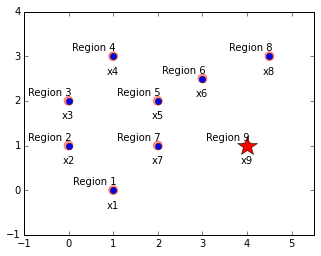

Number of hypotheses: 9
Number of decision regions: 9
Initial number of tests available: 36
Number of subregions: 9
Setting k=2
Subregion sets contained in 1 decision region:
	[0]
	[1]
	[2]
	[8]
	[3]
	[4]
	[5]
	[6]
	[7]
Shared subregion computation time: 0.000001 seconds
Initial hyperedge collection weight: 0.444

Starting iteration: 1
	Number of consistent hypotheses: 9
	Subregion 0 (member of decision regions : 1) still in contention
	Subregion 1 (member of decision regions : 2) still in contention
	Subregion 7 (member of decision regions : 8) still in contention
	Subregion 2 (member of decision regions : 3) still in contention
	Subregion 8 (member of decision regions : 9) still in contention
	Subregion 3 (member of decision regions : 4) still in contention
	Subregion 4 (member of decision regions : 5) still in contention
	Subregion 5 (member of decision regions : 6) still in contention
	Subregion 6 (member of decision regions : 7) still in contention
	Remaing Valid Multisets: 45
	Cu

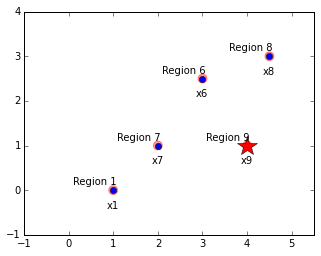

End iteration: 1 (0.000297 seconds)

Starting iteration: 2
	Number of consistent hypotheses: 5
	Subregion 0 (member of decision regions : 1) still in contention
	Subregion 7 (member of decision regions : 8) still in contention
	Subregion 8 (member of decision regions : 9) still in contention
	Subregion 5 (member of decision regions : 6) still in contention
	Subregion 6 (member of decision regions : 7) still in contention
	Remaing Valid Multisets: 15
	Current utility = 0.321
	Best Test: x1 ([1 0]) vs x6 ([ 3.   2.5])
	Largest Expected Marginal Gain: 0.481481
	Outcome: x6 ([ 3.   2.5])
	Number of tests remaining: 34
	Marking hypothesis x1 ([1 0]) as inconsistent
	Marking hypothesis x7 ([2 1]) as inconsistent


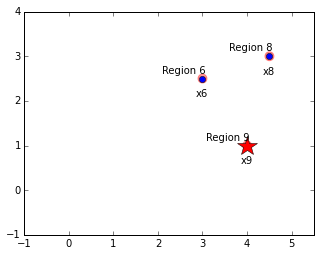

End iteration: 2 (0.000169 seconds)

Starting iteration: 3
	Number of consistent hypotheses: 3
	Subregion 7 (member of decision regions : 8) still in contention
	Subregion 8 (member of decision regions : 9) still in contention
	Subregion 5 (member of decision regions : 6) still in contention
	Remaing Valid Multisets: 6
	Current utility = 0.407
	Best Test: x6 ([ 3.   2.5]) vs x8 ([ 4.5  3. ])
	Largest Expected Marginal Gain: 0.086420
	Outcome: x6 ([ 3.   2.5])
	Number of tests remaining: 33
	Marking hypothesis x8 ([ 4.5  3. ]) as inconsistent


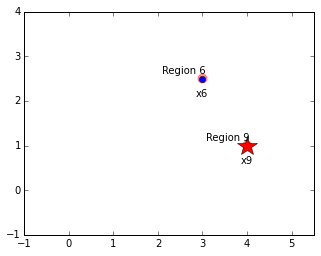

End iteration: 3 (0.000150 seconds)

Starting iteration: 4
	Number of consistent hypotheses: 2
	Subregion 8 (member of decision regions : 9) still in contention
	Subregion 5 (member of decision regions : 6) still in contention
	Remaing Valid Multisets: 3
	Current utility = 0.432
	Best Test: x6 ([ 3.   2.5]) vs x9 ([4 1])
	Largest Expected Marginal Gain: 0.024691
	Outcome: x9 ([4 1])
	Number of tests remaining: 32
	Marking hypothesis x6 ([ 3.   2.5]) as inconsistent


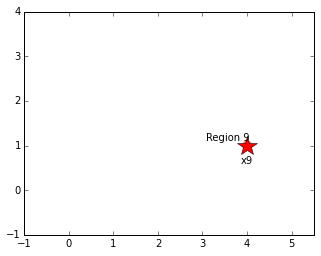

End iteration: 4 (0.000144 seconds)

Starting iteration: 5
	Number of consistent hypotheses: 1
	Subregion 8 (member of decision regions : 9) still in contention
	Remaing Valid Multisets: 1
	Current utility = 0.444
	All edges cut, breaking out of loop.

Ran for 5 iterations

Result: Choose Decision Region 9

Speed Test
Fast Version
	All edges cut, breaking out of loop.
CPU times: user 28.9 ms, sys: 72 µs, total: 29 ms
Wall time: 29.1 ms
Slow Version
	All edges cut, breaking out of loop.
CPU times: user 26.6 ms, sys: 335 µs, total: 26.9 ms
Wall time: 26.9 ms


In [30]:
run_one_hypothesis_per_decision_region_nonoverlapping_test()

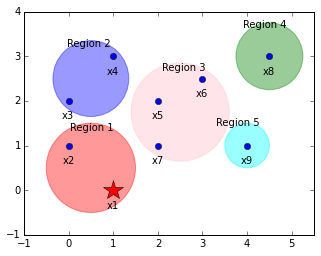

Number of hypotheses: 9
Number of decision regions: 5
Initial number of tests available: 31
Number of subregions: 5
Setting k=2
Subregion sets contained in 1 decision region:
	[2]
	[0]
	[3]
	[1]
	[4]
Shared subregion computation time: 0.000001 seconds
Initial hyperedge collection weight: 0.383

Starting iteration: 1
	Number of consistent hypotheses: 9
	Subregion 1 (member of decision regions : 2) still in contention
	Subregion 4 (member of decision regions : 5) still in contention
	Subregion 2 (member of decision regions : 3) still in contention
	Subregion 0 (member of decision regions : 1) still in contention
	Subregion 3 (member of decision regions : 4) still in contention
	Remaing Valid Multisets: 15
	Current utility = 0.000
	Best Test: x2 ([0 1]) vs x9 ([4 1])
	Largest Expected Marginal Gain: 2.814815
	Outcome: x2 ([0 1])
	Number of tests remaining: 30
	Marking hypothesis x5 ([2 2]) as inconsistent
	Marking hypothesis x6 ([ 3.   2.5]) as inconsistent
	Marking hypothesis x7 ([2 1]) 

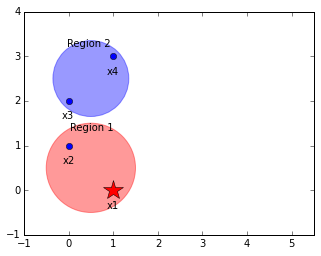

End iteration: 1 (0.000238 seconds)

Starting iteration: 2
	Number of consistent hypotheses: 4
	Subregion 1 (member of decision regions : 2) still in contention
	Subregion 0 (member of decision regions : 1) still in contention
	Remaing Valid Multisets: 3
	Current utility = 0.333
	Best Test: x1 ([1 0]) vs x4 ([1 3])
	Largest Expected Marginal Gain: 0.197531
	Outcome: x1 ([1 0])
	Number of tests remaining: 29
	Marking hypothesis x3 ([0 2]) as inconsistent
	Marking hypothesis x4 ([1 3]) as inconsistent


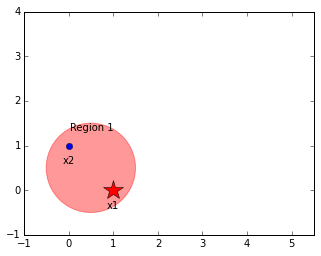

End iteration: 2 (0.000152 seconds)

Starting iteration: 3
	Number of consistent hypotheses: 2
	Subregion 0 (member of decision regions : 1) still in contention
	Remaing Valid Multisets: 1
	Current utility = 0.383
	All edges cut, breaking out of loop.

Ran for 3 iterations

Result: Choose Decision Region 1

Speed Test
Fast Version
	All edges cut, breaking out of loop.
CPU times: user 28.8 ms, sys: 286 µs, total: 29.1 ms
Wall time: 29.5 ms
Slow Version
	All edges cut, breaking out of loop.
CPU times: user 26.1 ms, sys: 269 µs, total: 26.3 ms
Wall time: 26.5 ms


In [27]:
run_multiple_hypothesis_per_decision_region_nonoverlapping_test()

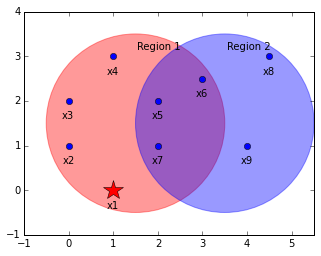

Number of hypotheses: 9
Number of decision regions: 2
Initial number of tests available: 8
Number of subregions: 3
Setting k=3
Subregion sets contained in 1 decision region:
	[0, 1]
	[2]
	[0]
	[1, 2]
	[1]
Shared subregion computation time: 0.000001 seconds
Initial hyperedge collection weight: 0.030

Starting iteration: 1
	Number of consistent hypotheses: 9
	Subregion 1 (member of decision regions : 1, 2) still in contention
	Subregion 2 (member of decision regions : 2) still in contention
	Subregion 0 (member of decision regions : 1) still in contention
	Remaing Valid Multisets: 10
	Current utility = 0.000
	Best Test: x1 ([1 0]) vs x8 ([ 4.5  3. ])
	Largest Expected Marginal Gain: 0.395062
	Outcome: x1 ([1 0])
	Number of tests remaining: 7
	Marking hypothesis x6 ([ 3.   2.5]) as inconsistent
	Marking hypothesis x8 ([ 4.5  3. ]) as inconsistent
	Marking hypothesis x9 ([4 1]) as inconsistent


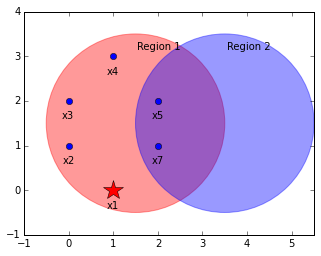

End iteration: 1 (0.000187 seconds)

Starting iteration: 2
	Number of consistent hypotheses: 6
	Subregion 1 (member of decision regions : 1, 2) still in contention
	Subregion 0 (member of decision regions : 1) still in contention
	Remaing Valid Multisets: 4
	Current utility = 0.052
	All edges cut, breaking out of loop.

Ran for 2 iterations

Result: Choose Decision Region 1

Speed Test
Fast Version
	All edges cut, breaking out of loop.
CPU times: user 24.2 ms, sys: 150 µs, total: 24.4 ms
Wall time: 24.5 ms
Slow Version
	All edges cut, breaking out of loop.
CPU times: user 20.7 ms, sys: 99 µs, total: 20.8 ms
Wall time: 20.9 ms


In [28]:
run_multiple_hypothesis_per_decision_region_overlapping_test()

Ground truth point: x1 ([ 7.85382389  2.84759143])
	Contained in decision regions: [0, 1]



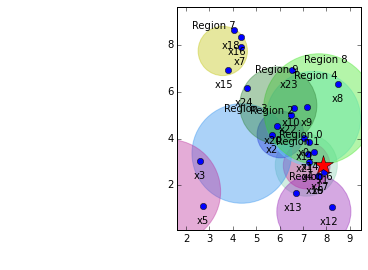

Number of hypotheses: 25
Number of decision regions: 10
Initial number of tests available: 181
Number of subregions: 15
Setting k=8
Subregion sets contained in 1 decision region:
	[0, 2, 12, 13]
	[0, 4, 8, 9, 12]
	[0, 4, 12, 13]
	[0, 2, 8, 9, 12, 13]
	[12]
	[1, 6]
	[1, 11]
	[2, 8, 12]
	[6, 10]
	[0, 2, 4, 8, 12, 13]
	[4, 9, 12]
	[12, 13, 14]
	[0, 4]
	[7]
	[6, 10, 11]
	[0, 4, 9, 13]
	[9, 14]
	[4, 8, 12, 13]
	[4, 8, 9, 12]
	[0, 8, 12]
	[9, 12, 13, 14]
	[0, 8, 9, 12]
	[8]
	[2, 4, 8, 13]
	[2, 8, 9, 13]
	[0, 4, 12]
	[2, 13, 14]
	[4, 12, 13]
	[0, 1]
	[0]
	[2, 4, 8, 12, 13]
	[8, 12]
	[2, 4, 8]
	[9, 12, 13]
	[2, 8, 12, 13]
	[0, 4, 6]
	[0, 12, 13]
	[2, 4, 12]
	[0, 4, 8, 12, 13]
	[2, 4, 8, 9, 12, 13]
	[0, 6, 11]
	[9]
	[8, 9]
	[4, 12]
	[0, 2, 8, 9, 12]
	[2, 12]
	[0, 1, 4]
	[4, 6, 11]
	[0, 2, 4, 8, 13]
	[0, 9, 13]
	[0, 8, 9, 12, 13]
	[4, 8, 9]
	[0, 1, 6]
	[1]
	[12, 13]
	[0, 1, 4, 6, 11]
	[6, 11]
	[0, 11]
	[2, 12, 13]
	[2, 9, 14]
	[2, 4, 9, 12]
	[4, 8, 13]
	[0, 2, 4, 8, 9, 13]
	[0, 1, 4, 6]
	[9, 13,

In [ ]:
run_random_test(num_hypotheses=25, num_decision_regions=10, do_speed_test=True)